In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import tensorflow as tf

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

In [3]:
# Define the true objective function z = f(x, y)
def obj_func(x):
    return -(20 * (np.exp(-0.2 * np.sqrt(0.5 * (x**2)))) - np.exp(0.5 * (np.cos(2 * np.pi * x))) + np.e + 20)

In [4]:
# Random Noise that will be added to data Response
ran_err = lambda n, x: np.random.normal(0, x, n)
sys_err = lambda n, x, a: (0.1 * a**2 - 0.5 * a + 2) + np.random.normal(0, x, n)

In [5]:
# Random Seed
np.random.seed(1)

# number of physical observations 
phy_n = 10 

# number of simulated observations
sim_n = 50

# Random Seed
r = np.random.default_rng(seed=2)

In [17]:
# Generate synthetic data for training the neural network
x_range = [(-5, 5)]

# Generate the meshgrid and response for the plots
X = np.arange(*x_range[0], ((x_range[0][1] - x_range[0][0]) / 1000))
Z = obj_func(X)

# Generate the initial physical experiments
df = pd.DataFrame(r.uniform(x_range[0][0], x_range[0][1], size=(phy_n, 1)))
df.columns = ["x"]
df["z"] = obj_func(df['x']) + ran_err(phy_n, 0.05)

#Generate Simulated Data
sim_df = pd.DataFrame(r.uniform(x_range[0][0], x_range[0][1], size=(sim_n, 1)))
sim_df.columns = ["x"]
sim_df["z"] = obj_func(sim_df['x']) + sys_err(sim_n, 0.02, sim_df['x'])

# Define the hyperparameter space
hyp_space  = [
    Integer(2, 10, name='num_layers'), # Num of layers in the network (depth)
    Integer(50, 200, name='num_units'), # Num of neurons in each hidden layer (width)
    Real(0.00001, 0.1, prior='log-uniform', name='learning_rate'), # Steps size at each iteration 
    Real(0.0, 0.5, name='dropout_rate'), # Probability of droping out a neuron
    Integer(20, 150, name='batch_size'), # Num of samples per batch
    Integer(50, 200, name='epochs') # Num of epochs (iterations over the entire dataset) during training
]

In [27]:
# Defining the Neural Network Model
def NN_model(num_layers, num_units, learning_rate, dropout_rate):
    inputs = Input(shape=(1,))
    x = Dense(num_units, activation='relu', kernel_regularizer='l2')(inputs)
    for _ in range(num_layers - 1):
        x = Dense(num_units, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Fit Initial Physical Experiments
krnl = C(1, (1e-3, 1e3)) * RBF(length_scale=1, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))
model2 = GaussianProcessRegressor(kernel=krnl, normalize_y=True, random_state=3)
model2.fit(df[["x"]], df["z"])
mean, std = model2.predict(X.reshape(-1,1), return_std=True)

# Define the objective function to minimize
@use_named_args(hyp_space)
def objective(**params):
    num_layers = params['num_layers']
    num_units = params['num_units']
    learning_rate = params['learning_rate']
    dropout_rate = params['dropout_rate']
    batch_size = params['batch_size']
    epochs = params['epochs']

    model = NN_model(num_layers, num_units, learning_rate, dropout_rate)

    # kfold = KFold(n_splits=3)
    # scores = []

    # for train_idx, val_idx in kfold.split(X):
    #     model.fit(X[train_idx], Z[train_idx], epochs=epochs, batch_size=batch_size, verbose=0)
    #     score = model.evaluate(X[val_idx], Z[val_idx], verbose=0)
    #     scores.append(score)
    
    # return np.mean(scores)
    
    model.fit(sim_df["x"], sim_df["z"], epochs=epochs, batch_size=batch_size, verbose=0)
    score = model.evaluate(sim_df["x"], sim_df["z"], verbose=0)
    return score



# Perform Bayesian optimization
result = gp_minimize(objective, hyp_space, n_calls=30, random_state=0, acq_func='EI')

# Output best hyperparameters from BayesOpt
print("Best hyperparameters:")
print("num_layers:", result.x[0])
print("num_units:", result.x[1])
print("learning_rate:", result.x[2])
print("dropout_rate:", result.x[3])
print("batch_size:", result.x[4])
print("epochs:", result.x[5])

# Train the model with the best hyperparameters
best_model = NN_model(
    num_layers=result.x[0],
    num_units=result.x[1],
    learning_rate=result.x[2],
    dropout_rate=result.x[3],
)

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(


Best hyperparameters:
num_layers: 3
num_units: 195
learning_rate: 0.00409788855418806
dropout_rate: 0.08545479256802259
batch_size: 67
epochs: 163


In [29]:
# Function for MC Dropout predictions
def mc_dropout_predictions(model, X, num_samples=100):
    predictions = np.zeros((num_samples, X.shape[0]))
    for i in range(num_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std

# Function to sample new data points based on uncertainty
def sample_new_points(model, X, n_samples=5):
    _, std = mc_dropout_predictions(model, X)
    high_uncertainty_indices = np.argsort(std)[-n_samples:]
    return high_uncertainty_indices

In [30]:
# Fit Model of Simulated Data
best_model.fit(sim_df["x"], sim_df["z"], epochs=result.x[5], batch_size=result.x[4], verbose=1)

Epoch 1/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1121.4954
Epoch 2/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1068.6022
Epoch 3/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1013.7184
Epoch 4/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 935.0602
Epoch 5/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 832.9677
Epoch 6/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 713.8383
Epoch 7/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 569.4934
Epoch 8/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 430.2256
Epoch 9/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 344.0334
Epoch 10/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 359.3705
Epoch 11/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 461.2733
Epoch 12/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 497.9840
Epoch 13/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 445.8221
Epoch 14/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 348.4677
Epoch 15/163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - los

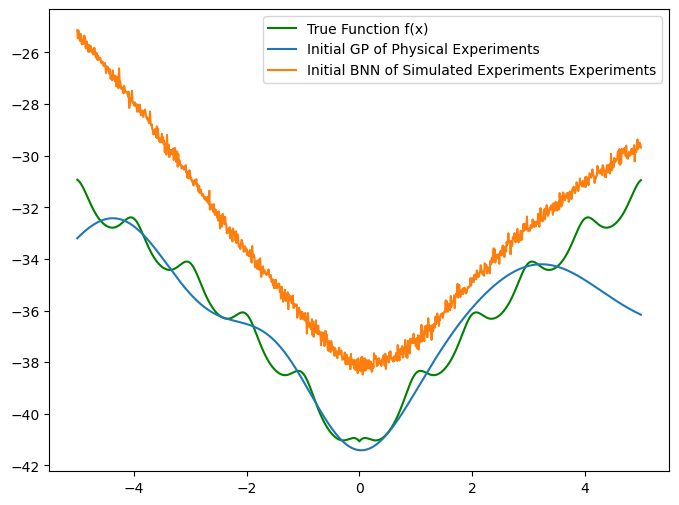

In [34]:
# Plotting the results
import matplotlib.pyplot as plt

sim_mean, sim_std = mc_dropout_predictions(best_model, X)

plt.figure(figsize=(8, 6))
plt.plot(X, Z, label='True Function f(x)', color='green')
plt.plot(X, mean, label="Initial GP of Physical Experiments")
plt.plot(X, sim_mean, label="Initial BNN of Simulated Experiments Experiments")
plt.legend()
plt.show()

In [67]:
# Active Learning Loop
def perform_iteration(df):
    # Generate predictions and uncertainties
    _, uncertainties = mc_dropout_predictions(best_model, X_simulated)
    
    # Select new points to sample based on high uncertainty
    new_points_indices = sample_new_points(best_model, X_simulated, n_samples=phy_n)
    new_X = X_simulated[new_points_indices]
    new_y = y_simulated[new_points_indices]
    
    # Add new points to the training data
    X_physical = np.concatenate([X_physical, new_X])
    y_physical = np.concatenate([y_physical, new_y])
    
    # Retrain the model on the updated training data
    best_model.fit(X_physical, y_physical, epochs=result.x[5] // 2, batch_size=result.x[4], verbose=1)

    # Evaluate the model on the physical data
    evaluation = best_model.evaluate(X_physical, y_physical)
    print(f"Iteration {i + 1}, Evaluation on physical data: {evaluation}")

# Generate predictions with MC Dropout
test_x = np.linspace(-5, 5, 100).reshape(-1, 1)
test_x_scaled = scaler.transform(test_x)
mean, std = mc_dropout_predictions(best_model, test_x_scaled)

Epoch 1/92
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.1354
Epoch 2/92
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.0763
Epoch 3/92
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.1461
Epoch 4/92
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.7998
Epoch 5/92
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.3520
Epoch 6/92
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.0015
Epoch 7/92
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.8187
Epoch 8/92
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.3539
Epoch 9/92
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.4371
Epoch 10/92
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.3452
Epoch 11/92
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.8934
Epoch 12/92
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.5237
Epoch 13/92
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.8888
Epoch 14/92
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.0192
Epoch 15/92
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.9460
Epoch 16/92
1/1 ━━━━━━━━━━━━━━━━━━

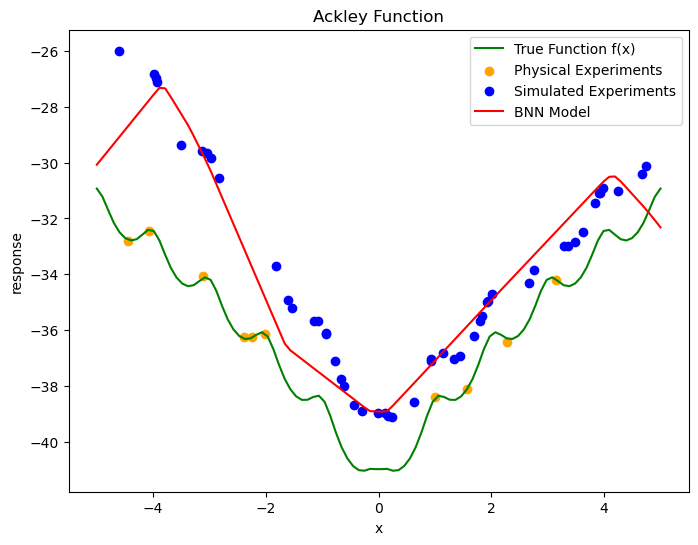

In [71]:
# Plotting the results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(test_x, obj_func(test_x), label='True Function f(x)', color='green')
plt.scatter(df['x'], df['z'], label='Physical Experiments', color='orange')
plt.scatter(sim_df['x'], sim_df['z'], label='Simulated Experiments', color='blue')
plt.plot(test_x, mean, label='BNN Model', color='red')
plt.fill_between(test_x.flatten(), mean - 1.96 * std, mean + 1.96 * std, alpha=0.5)
plt.xlabel('x')
plt.ylabel('response')
plt.title('Ackley Function')
plt.legend()
plt.show()